# Analysis Data of Rating Zomato Resturant 
### In this project, we intend to analyze the data of Zomato restaurant and review their ranking method 


### Table content: The steps will generally be as follows:
- Extract and convert data to standard CSV
- Normalize many data
- The information is divided into two segment
- Clustering feature with k-means method unsupervised
- Merging clusters and sticking the label to data about delivery and classy ambiance
- Classification data for predicting user ratting
- Analysis functionality method be run


##### Developed by: M.khaki

#### Data from: kaggle.com


In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import json
import csv
import os
from sklearn import svm
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from collections import Counter
import itertools
import pylab
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, ClusterWarning
from warnings import simplefilter
from sklearn.cluster import AgglomerativeClustering 
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.datasets import load_iris

itemNumberFile=[75,75,75,75,68]

## Extracte and Convert Data to Standard CSV
In this block, the required for this project is extracted five JSON data from the zomato restaurant on the Kaggle website.
Also, these items have been converted from JSON to CSV for further analysis

In [2]:
def selection_json(values,iterate):
    for i in range(iterate):
        for value in values[i]["restaurants"]:
            item = {
                "id": value["restaurant"]["R"]["res_id"],
                "has_online_delivery":value["restaurant"]["has_online_delivery"],
                "has_table_booking":value["restaurant"]["has_table_booking"],
                "is_delivering_now":value["restaurant"]["is_delivering_now"],
                "switch_to_order_menu":value["restaurant"]["switch_to_order_menu"],
                "cuisines":len(value["restaurant"]["cuisines"].split(",")),
                "average_cost_for_two":value["restaurant"]["average_cost_for_two"],
                "price_range":value["restaurant"]["price_range"],
                "votes":value["restaurant"]["user_rating"]["votes"],
                "aggregate_rating":value["restaurant"]["user_rating"]["aggregate_rating"],
                "currency":value["restaurant"]["currency"],
                
                }
            data.append(item)

data=[]
jsonFile = open('data/file1.json')
values = json.load(jsonFile)
jsonFile.close()
selection_json(values,itemNumberFile[0])
jsonFile = open('data/file2.json')
values = json.load(jsonFile)
jsonFile.close()
selection_json(values,itemNumberFile[1])
jsonFile = open('data/file3.json')
values = json.load(jsonFile)
jsonFile.close()
selection_json(values,itemNumberFile[2])
jsonFile = open('data/file4.json')
values = json.load(jsonFile)
jsonFile.close()
selection_json(values,itemNumberFile[3])
jsonFile = open('data/file5.json')
values = json.load(jsonFile)
jsonFile.close()
selection_json(values,itemNumberFile[4])
jsonData=json.dumps(data)
df = pd.read_json(jsonData)
df.to_csv('zomato_df.csv')
df.drop_duplicates(subset=['id'])
df.drop(df[(df["currency"]!= "$") & (df["currency"]!= "Rs.") & (df["currency"]!= "AED") & (df["currency"]!= "TL") & (df["currency"]!= "£") & (df["currency"]!= "QR") & (df["currency"]!= "LKR") & (df["currency"]!= "R$") & (df["currency"]!= "NZ$") & (df["currency"]!= "IDR")].index, inplace = True)

In [3]:
df.describe()

,id,has_online_delivery,has_table_booking,is_delivering_now,switch_to_order_menu,cuisines,average_cost_for_two,price_range,votes,aggregate_rating
count,5.733000e+03,5733.000000,5733.000000,5733.000000,5733.0,5733.00000,5733.000000,5733.000000,5733.000000,5733.000000
mean,8.710778e+06,0.216641,0.173208,0.001395,0.0,2.41514,2551.251526,2.301413,601.936682,3.440241
std,8.455471e+06,0.411992,0.378460,0.037333,0.0,1.25012,23299.771393,0.971071,1013.253863,1.236149
min,5.500000e+01,0.000000,0.000000,0.000000,0.0,1.00000,0.000000,1.000000,0.000000,0.000000
25%,3.029220e+05,0.000000,0.000000,0.000000,0.0,1.00000,150.000000,2.000000,28.000000,3.300000
50%,5.602586e+06,0.000000,0.000000,0.000000,0.0,2.00000,500.000000,2.000000,153.000000,3.800000
75%,1.815738e+07,0.000000,0.000000,0.000000,0.0,3.00000,1200.000000,3.000000,704.000000,4.200000
max,1.849649e+07,1.000000,1.000000,1.000000,0.0,8.00000,800000.000000,4.000000,10934.000000,4.900000


Change vote to vote/max

In [4]:
vote_max=df["votes"].max()
df["votes"]=df["votes"]/vote_max

Convert currency to doller 

In [5]:
currency_convert = df[["average_cost_for_two","currency"]].values
for i in range(len(currency_convert)):
    if(currency_convert[i][1]=="Rs."):
        currency_convert[i][0]*=0.013
    if(currency_convert[i][1]=="AED"):
        currency_convert[i][0]*=0.27
    if(currency_convert[i][1]=="TL"):
        currency_convert[i][0]*=0.074        
    if(currency_convert[i][1]=="£"):
        currency_convert[i][0]*=1.35        
    if(currency_convert[i][1]=="QR"):
        currency_convert[i][0]*=0.27        
    if(currency_convert[i][1]=="LKR"):
        currency_convert[i][0]*=0.0049        
    if(currency_convert[i][1]=="R$"):
        currency_convert[i][0]*=0.06244  
    if(currency_convert[i][1]=="NZ$"):
        currency_convert[i][0]*=0.68 
    if(currency_convert[i][1]=="IDR"):
        currency_convert[i][0]*=0.00007
    else:
        currency_convert[i][0]=currency_convert[i][0]

## Normalize items of classification2
cuisines, average cost for two, price range and votes should be normalized between 0 and 1

In [6]:
df.columns

Index(['id', 'has_online_delivery', 'has_table_booking', 'is_delivering_now',
       'switch_to_order_menu', 'cuisines', 'average_cost_for_two',
       'price_range', 'votes', 'aggregate_rating', 'currency'],
      dtype='object')

Transformation some data from pandas to numpy for standard use in scikit learn

In [7]:
c2=df[["cuisines","average_cost_for_two","price_range","votes"]].values
c1=df[["id", "has_online_delivery", "has_table_booking", "is_delivering_now","switch_to_order_menu","aggregate_rating"]].values
df = pd.DataFrame(data=c1 , columns=["id", "has_online_delivery", "has_table_booking", "is_delivering_now","switch_to_order_menu","aggregate_rating"])

Normalize data with min-max scaler 

In [8]:
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(c2)
c2=scaler.transform(c2)
c2 = pd.DataFrame(data=c2 , columns=["cuisines","average_cost_for_two","price_range","votes"])

Concat class1 and normalized class2 & Ronded aggregate_rating parameter

In [9]:
data = pd.concat([df, c2], axis=1)
data.loc[(data["aggregate_rating"] >= 4.5), 'aggregate_rating'] = 5
data.loc[(data["aggregate_rating"] >= 3.8) & (data["aggregate_rating"] < 4.5), 'aggregate_rating'] = 4
data.loc[(data["aggregate_rating"] >= 2.8) & (data["aggregate_rating"] < 3.8), 'aggregate_rating'] = 3
data.loc[(data["aggregate_rating"] >= 1.8) & (data["aggregate_rating"] < 2.8), 'aggregate_rating'] = 2
data.loc[(data["aggregate_rating"] < 1.8), 'aggregate_rating'] = 1
data["aggregate_rating"]=data["aggregate_rating"].astype(int)
data.head()

,id,has_online_delivery,has_table_booking,is_delivering_now,switch_to_order_menu,aggregate_rating,cuisines,average_cost_for_two,price_range,votes
0,308322.0,1.0,1.0,0.0,0.0,4,0.428571,0.002000,0.666667,0.725352
1,18037817.0,0.0,1.0,0.0,0.0,5,0.714286,0.001875,0.666667,0.071154
2,312345.0,1.0,0.0,0.0,0.0,4,0.428571,0.001063,0.333333,0.140571
3,307490.0,0.0,1.0,0.0,0.0,4,0.142857,0.002313,0.666667,0.166728
4,18241537.0,0.0,1.0,0.0,0.0,4,0.428571,0.002000,0.666667,0.076825


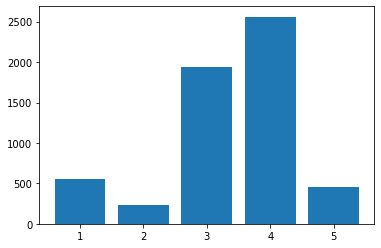

In [10]:
rating_histogram = Counter(data["aggregate_rating"])
plt.bar(rating_histogram.keys(), rating_histogram.values())
plt.show()

Pre processing and Check data type

In [11]:
data.dtypes

id                      float64
has_online_delivery     float64
has_table_booking       float64
is_delivering_now       float64
switch_to_order_menu    float64
aggregate_rating          int32
cuisines                float64
average_cost_for_two    float64
price_range             float64
votes                   float64
dtype: object

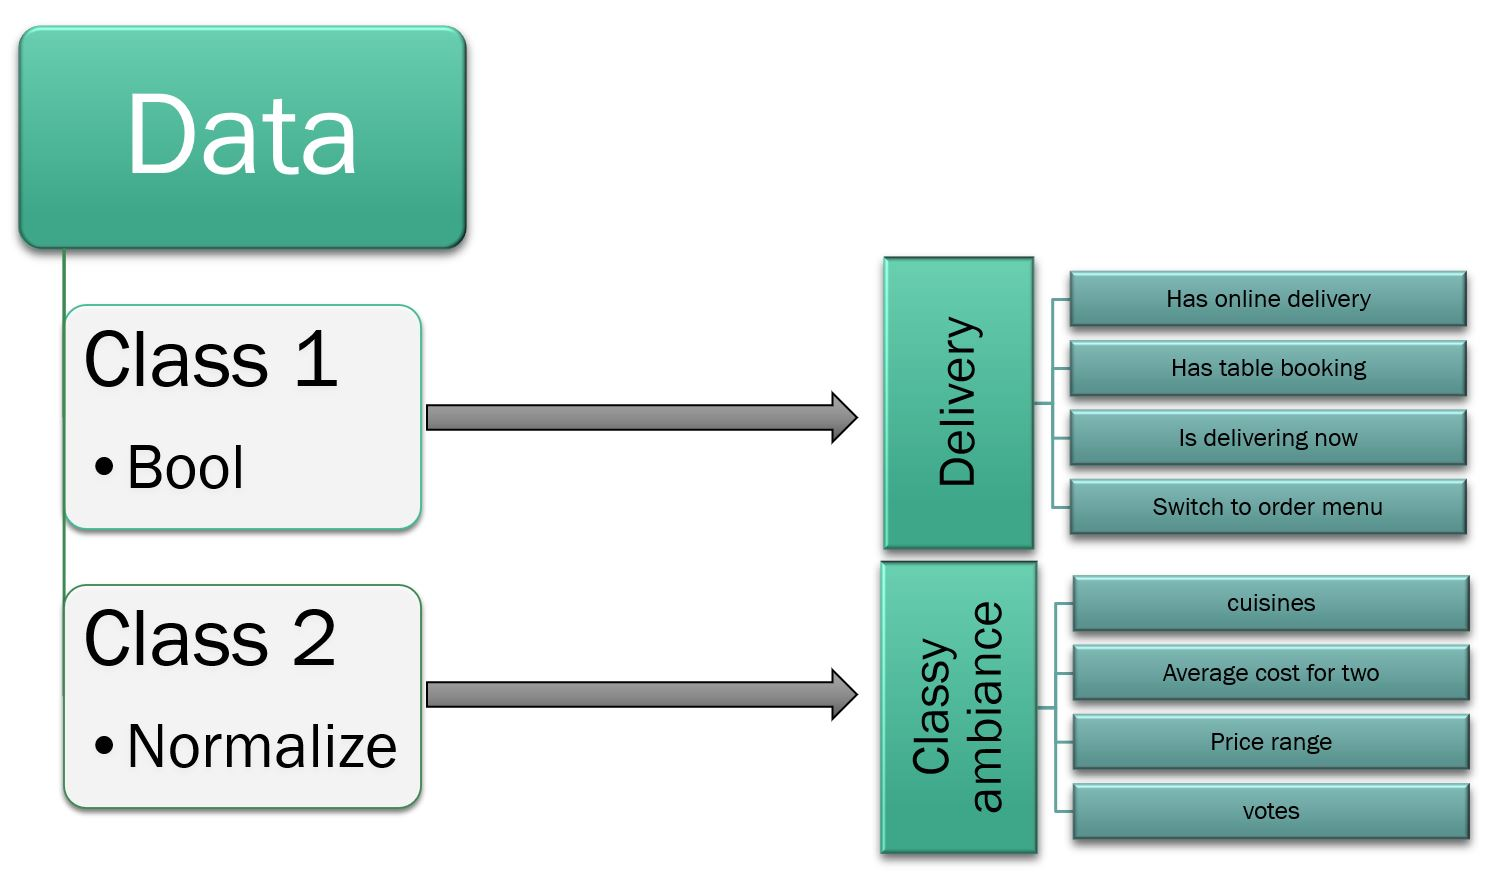

In [12]:
feature_c1 = data[["has_online_delivery", "has_table_booking", "is_delivering_now","switch_to_order_menu"]]
feature_c2 = data[["cuisines","average_cost_for_two","price_range","votes"]]
from IPython import display
display.Image("image/Capture.JPG")

# Clustering
Hierarchical Cluster1

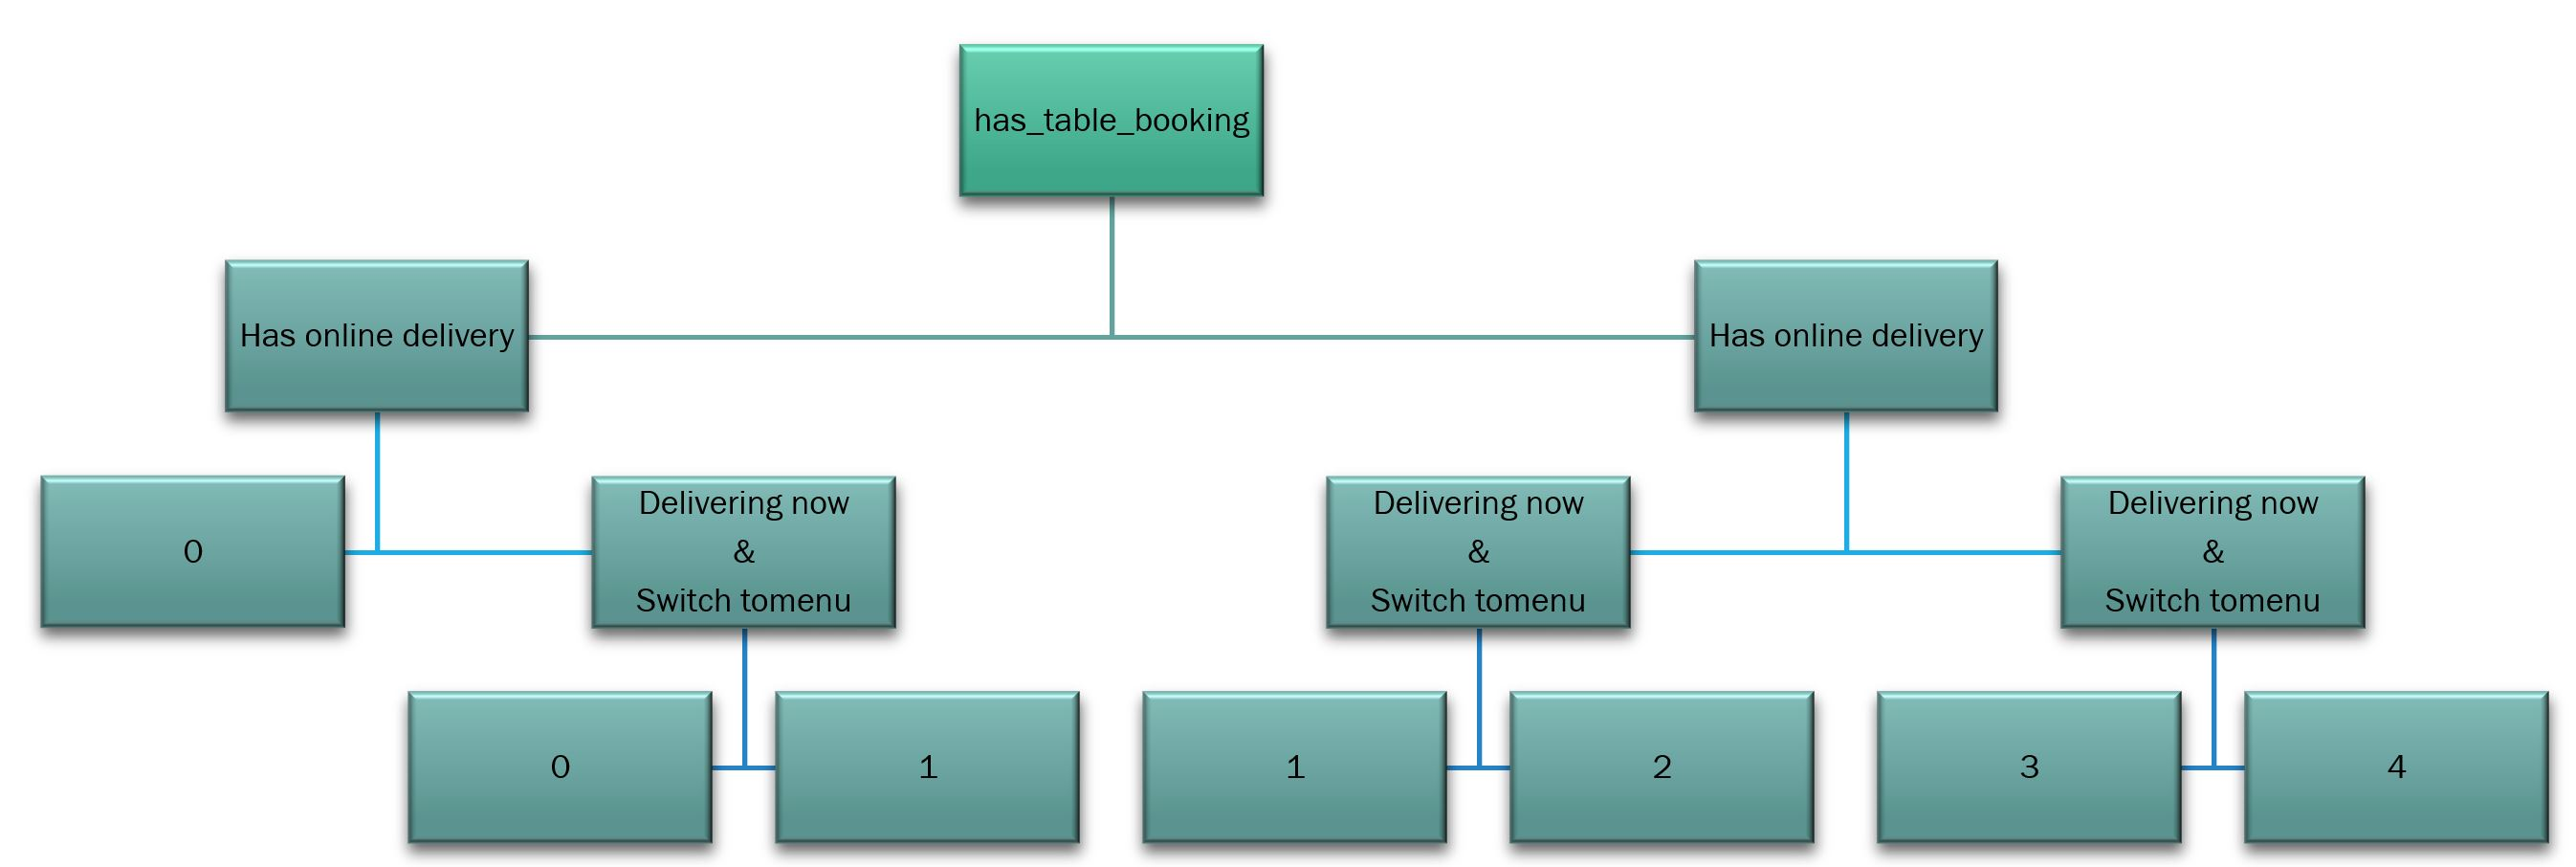

In [13]:
display.Image("image/hierarchy.JPG")

In [14]:
def computeDeliveryTree(temp_tree):
    if(temp_tree[1]==0):
        if(temp_tree[0]==0):
            return 0
        if(temp_tree[0]==1 and temp_tree[2]+temp_tree[3]<2):
            return 0
        if(temp_tree[0]==1 and temp_tree[2]+temp_tree[3]==2):
            return 1       
    if(temp_tree[1]==1):
        if(temp_tree[0]==0 and temp_tree[2]+temp_tree[3]<2):
            return 1
        if(temp_tree[0]==0 and temp_tree[2]+temp_tree[3]==2):
            return 2
        if(temp_tree[0]==1 and temp_tree[2]+temp_tree[3]<2):
            return 3
        if(temp_tree[0]==1 and temp_tree[2]+temp_tree[3]==2):
            return 4
temp_tree = feature_c1.values
temp_label = []
temp_rate = pd.DataFrame(data=data["aggregate_rating"] , columns=["aggregate_rating"])
temp_rate = temp_rate["aggregate_rating"].values
for i in range(len(temp_rate)):
    temp_rate[i]=temp_rate[i]-1
for i in range(temp_tree.shape[0]):
    temp_label.append(computeDeliveryTree(temp_tree[i]))
temp_label = np.array(temp_label)
temp_arr = pd.DataFrame({'temp_label': temp_label,'temp_rate': temp_rate}) 
temp_arr = temp_arr.values
dist_matrix = euclidean_distances(temp_arr,temp_arr) 

with k-means method

In [15]:
simplefilter("ignore", ClusterWarning)
hierarchy1 = linkage(dist_matrix, 'average')
labels1 = fcluster(hierarchy1, 5, criterion='maxclust')
for i in range(len(labels1)):
    labels1[i]=labels1[i]-1

k_means2 = KMeans(init = "k-means++", n_clusters = 5, n_init = 20)
k_means2.fit(feature_c2)
labels2 = k_means2.labels_

Sorting classfy label

# Set label with CoEfficient

In [16]:
permutationsArray = np.asarray(list(itertools.permutations([1, 2, 3, 4, 5])))
co_Class = pd.DataFrame(data=permutationsArray[0][labels1] , columns=["classifier"])
lut = np.zeros_like(np.arange(5))

coefficient = 0
for i in range(len(permutationsArray)):
    lut = permutationsArray[i]
    co_Class["classifier"]=lut[labels1]
    co_Score = co_Class["classifier"].corr(data["aggregate_rating"])
    if(coefficient < co_Score):
        coefficient = co_Score
        highCoef1 = lut
for i in range(len(highCoef1)):
    if(highCoef1[i]==1):
        labels1_minIndex = i
for i in range(len(highCoef1[labels1])):
    if(temp_tree[i][0]==0 and temp_tree[i][1]==0):
        labels1[i]=labels1_minIndex
        
        
coefficient = 0
for i in range(len(permutationsArray)):
    lut = permutationsArray[i]
    co_Class["classifier"]=lut[labels2]
    co_Score = co_Class["classifier"].corr(data["aggregate_rating"])
    if(coefficient < co_Score):
        coefficient = co_Score
        highCoef2 = lut

        

data["Delivery"] = highCoef1[labels1]
data["Ambiance"] = highCoef2[labels2]

print(data["Delivery"].corr(data["aggregate_rating"]))
print(data["Ambiance"].corr(data["aggregate_rating"]))

0.19589331610470598
0.4568155452571021


## Stick label from result clustering 

In [17]:
data.loc[(data["Delivery"] >= 3) & (data["Ambiance"] >= 3), 'output label'] = 'Delivery & Classy ambiance'
data.loc[(data["Delivery"] >= 3) & (data["Ambiance"] < 3), 'output label'] = 'Delivery'
data.loc[(data["Delivery"] < 3) & (data["Ambiance"] >= 3), 'output label'] = 'Classy ambiance'
data.loc[(data["Delivery"] < 3) & (data["Ambiance"] < 3), 'output label'] = 'Not any'
data.head()

,id,has_online_delivery,has_table_booking,is_delivering_now,switch_to_order_menu,aggregate_rating,cuisines,average_cost_for_two,price_range,votes,Delivery,Ambiance,output label
0,308322.0,1.0,1.0,0.0,0.0,4,0.428571,0.002000,0.666667,0.725352,4,5,Delivery & Classy ambiance
1,18037817.0,0.0,1.0,0.0,0.0,5,0.714286,0.001875,0.666667,0.071154,5,5,Delivery & Classy ambiance
2,312345.0,1.0,0.0,0.0,0.0,4,0.428571,0.001063,0.333333,0.140571,3,2,Delivery
3,307490.0,0.0,1.0,0.0,0.0,4,0.142857,0.002313,0.666667,0.166728,3,3,Delivery & Classy ambiance
4,18241537.0,0.0,1.0,0.0,0.0,4,0.428571,0.002000,0.666667,0.076825,3,5,Delivery & Classy ambiance


In [18]:
zomato_csv = pd.read_csv('data/zomato.csv',encoding='ISO-8859-1')
zomato_csv = zomato_csv[["Restaurant ID","Restaurant Name","Country Code","City"]]
countryCode = pd.read_excel('data/Country-Code.xlsx')

zomato_csv.columns = ["id", "Restaurant Name", "Country Code", "City"]
countryCode.columns = ["Country Code", "Country"]
data["id"]=data["id"].astype(int)
data_merge = data[["id", "Delivery", "Ambiance", "aggregate_rating", "output label"]] 


result = pd.merge(zomato_csv, countryCode, how="inner", on="Country Code")
result = result[["id", "Restaurant Name", "Country"]]
result = pd.merge(result, data_merge, how="inner", on="id")
result

,id,Restaurant Name,Country,Delivery,Ambiance,aggregate_rating,output label
0,6600681,Chez Michou,Brazil,1,2,3,Not any
1,6601005,Cafí© Daniel Briand,Brazil,1,1,4,Not any
2,6600292,Casa do Biscoito Mineiro,Brazil,1,2,3,Not any
3,6600441,Maori,Brazil,1,3,4,Classy ambiance
4,6600970,Pizza íæ Bessa,Brazil,1,2,3,Not any
...,...,...,...,...,...,...,...
5722,5915730,NamlÛ± Gurme,Turkey,1,3,4,Classy ambiance
5723,5908749,Ceviz AÛôacÛ±,Turkey,1,3,4,Classy ambiance
5724,5915807,Huqqa,Turkey,1,4,3,Classy ambiance
5725,5916112,Aôôk Kahve,Turkey,1,4,4,Classy ambiance


In [19]:
result[result["Delivery"]!=1]

,id,Restaurant Name,Country,Delivery,Ambiance,aggregate_rating,output label
1161,5704255,Famous Dave's Barbecue,UAE,5,4,5,Delivery & Classy ambiance
1162,5701978,Pizza Di Rocco,UAE,4,3,4,Delivery & Classy ambiance
1167,5700052,Cho Gao - Crowne Plaza Abu Dhabi,UAE,4,4,4,Delivery & Classy ambiance
1168,5702418,Gazebo,UAE,4,5,4,Delivery & Classy ambiance
1169,5700386,Sangeetha Vegetarian Restaurant,UAE,3,2,3,Delivery
...,...,...,...,...,...,...,...
5627,6103868,Nobu,United Kingdom,3,4,4,Delivery & Classy ambiance
5628,6104220,Roti Chai,United Kingdom,5,3,5,Delivery & Classy ambiance
5639,6800569,Chaophraya,United Kingdom,3,4,4,Delivery & Classy ambiance
5651,6801873,Mr Cooper's House & Garden - The Midland,United Kingdom,3,3,4,Delivery & Classy ambiance


# Over sampling
oversampling helps to data balance on user rating

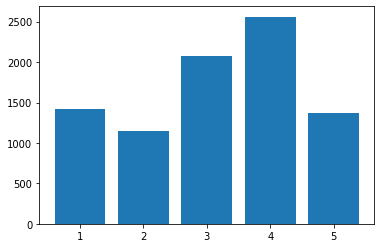

In [20]:
from imblearn.over_sampling import SMOTE
oversampel_x=data[["id", "has_online_delivery", "has_table_booking", "is_delivering_now","switch_to_order_menu","cuisines","average_cost_for_two","price_range","votes", "Delivery", "Ambiance"]].values
oversampel_y=data[["aggregate_rating"]].values

ratingCount = []
temp_key = []
for i in range(1,6):  
    ratingCount.append(data.loc[(data["aggregate_rating"] == i )].count().aggregate_rating)
max_key = ratingCount.index(np.max(ratingCount))+1
min_key = ratingCount.index(np.min(ratingCount))+1
if(ratingCount[max_key-1]*0.45 > ratingCount[min_key-1]):
    max_value = ratingCount[max_key-1]
    min_value = (max_value*0.45).astype(int)
else:
    max_value = ratingCount[max_key-1]
    min_value=ratingCount[min_key-1]
    
temp_value = []
temp_grow = []   
for i in range(5):
    if(i!= max_key-1 and i!= min_key-1):
        temp_key.append(i+1) 
for i in range(3):
    temp_grow.append(ratingCount[temp_key[i]-1]/ratingCount[min_key-1])
temp_grow_sum = sum(temp_grow)
for i in range(3):
    temp_grow[i]=temp_grow[i]/temp_grow_sum
for i in range(3):
    temp_value.append(((max_value - min_value)*(temp_grow[i]) + min_value).astype(int)) 
    
    
strategy = {
    max_key: max_value,
    min_key: min_value,
    temp_key[0]: temp_value[0],
    temp_key[1]: temp_value[1],
    temp_key[2]: temp_value[2],
}
oversample = SMOTE(sampling_strategy=strategy)
oversampel_x, oversampel_y = oversample.fit_resample(oversampel_x, oversampel_y)
counter = Counter(oversampel_y)
oversampel_x = pd.DataFrame(data=oversampel_x , columns=["id", "has_online_delivery", "has_table_booking", "is_delivering_now","switch_to_order_menu","cuisines","average_cost_for_two","price_range","votes", "Delivery", "Ambiance"])
oversampel_y = pd.DataFrame(data=oversampel_y , columns=["aggregate_rating"])
data = pd.concat([oversampel_x, oversampel_y], axis=1)

plt.bar(counter.keys(), counter.values())
plt.show()

In [21]:
x_temp = pd.DataFrame(data=data , columns=["id", "has_online_delivery", "has_table_booking", "is_delivering_now","switch_to_order_menu","cuisines","average_cost_for_two","price_range","votes", "Delivery", "Ambiance","aggregate_rating"])
x_temp.drop(x_temp[(x_temp["has_online_delivery"]+x_temp["has_table_booking"]+x_temp["is_delivering_now"]+x_temp["switch_to_order_menu"] == 0)].index, inplace = True)
x = x_temp[["Delivery", "Ambiance"]]
y = x_temp["aggregate_rating"]
x=np.asarray(x)
y=np.asarray(y).ravel()

## Train/Test
Split data to two part train,test

The SVM algorithm offers a choice of kernel functions for performing its processing. Basically, mapping data into a higher dimensional space is called kernelling.

1. Linear
2. Polynomial
3. Gaussian Radial basis function (RBF)
4. Sigmoid

In [22]:
x_train , x_test , y_train , y_test = train_test_split(x , y , test_size=0.3 , random_state=5)

Comparison kernel method of svm

In [23]:
ks=[]
kernels = ["linear", "poly", "rbf"]
for i in kernels:
    clf_test=svm.SVC(kernel=i)
    clf_test.fit(x_train,y_train)
    yhat_test=clf_test.predict(x_test)
    ks.append(cohen_kappa_score(y_test, yhat_test))
ksd = {'linear': [ks[0]], 'poly': [ks[1]], 'gaussian rbf': [ks[2]]}
ksd

{'linear': [0.646764978032004],
 'poly': [0.5926713095622143],
 'gaussian rbf': [0.6469446929602363]}

Predict user rating with supervise

In [24]:
clf=svm.SVC(kernel="rbf",gamma=10)
clf.fit(x_train,y_train)
yhat=clf.predict(x_test)

## Confusion matrix and Analysis

In this section, we calculate the accuracy, but since the kappa score is a better benchmark for multi-tag data, we use it as follows:

- Kappa Less Than 0: "VERY BAD"
- Kappa between 0 to 20: "BAD"
- Kappa between 20 to 60: "MIDDLE"
- Kappa between 60 to 80: "GOOD"
- Kappa between 80 to 100: "EXCELLENT"

In [25]:
delivery_no = (data["Ambiance"].corr(data["aggregate_rating"]))*(data["id"].count() - x_temp["id"].count())
delivery_yes = (cohen_kappa_score(y_test, yhat))*(x_temp["id"].count())
kappa_score = (delivery_no + delivery_yes)/(data["id"].count())
kappa_score = (kappa_score*100).astype(int)

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           1       0.89      1.00      0.94        51
           2       0.88      0.95      0.92       192
           3       0.64      0.57      0.60       182
           4       0.74      0.81      0.77       283
           5       0.97      0.67      0.79        87

    accuracy                           0.78       795
   macro avg       0.82      0.80      0.80       795
weighted avg       0.78      0.78      0.78       795

Kappa Score 58


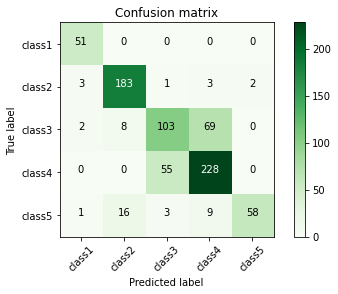

In [27]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,2,3,4,5])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))
print("Kappa Score" , kappa_score)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['class1','class2','class3','class4','class5'],normalize= False,  title='Confusion matrix')

## Accuracy curve Plot 

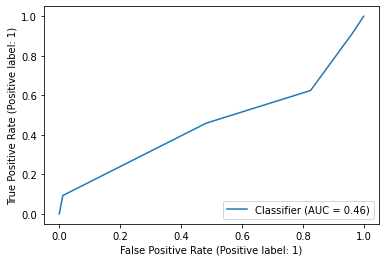

In [28]:
def normalize_numpy(arr):
    norm = np.linalg.norm(arr)
    normal_array = arr/norm
    return normal_array
y_true = y_test == yhat
y_pred = normalize_numpy(yhat)

RocCurveDisplay.from_predictions(y_true, y_pred)
plt.show()

In [29]:
def predict_new_resturant(f1,f2,f3,f4,f5,f6,f7,f8):
    output=[]
    
    new_input1 = np.array([f1,f2,f3,f4])
    score1 = computeDeliveryTree(new_input1)+1
    
    new_input2 = np.array([f5,f6,f7,f8])
    df_input2 = pd.DataFrame(data=new_input2.reshape(1, -1) , columns=["cuisines","average_cost_for_two","price_range","votes"])
    df_input2 = df_input2.values
    df_input2=scaler.transform(df_input2)
    new_input2 = df_input2[0]
    new_input2[3] = f8
    temp_dist = 0
    score2 = 0
    for i in range(5):
        dist = np.linalg.norm(df_input2 - k_means2.cluster_centers_[i])
        if(temp_dist > dist or i==0):
            temp_dist = dist
            score2 = i  
    new_x = np.array([score1,highCoef2[score2]]).reshape(1, -1)
    new_yhat=clf.predict(new_x)
    
    
    if(f1+f2+f3+f4 == 0):
        output.append(score1)
        output.append(highCoef2[score2])
        output.append(new_yhat[0])
    else:
        output.append(score1)
        output.append(highCoef2[score2])
        output.append(highCoef2[score2])                
 
    return output

In [30]:
f1=0                #has_online_delivery
f2=1                #has_table_booking
f3=0                #is_delivering_now
f4=0                #switch_to_order_menu
f5=1                #cuisines
f6=1200             #average_cost_for_two
f7=3                #price_range

f8=data["votes"].mean()
output = predict_new_resturant(f1,f2,f3,f4,f5,f6,f7,f8)
cluster_input1= output[0]
cluster_input2= output[1]
new_yhat= output[2]

if(cluster_input1>=3 and cluster_input2>=3):
    print("This resturant have: 'Good Delivery & High Classy ambiance' And user rate predict %d out of 5" % (new_yhat))
elif(cluster_input1>=3 and cluster_input2<3):
    print("This resturant have: 'Good Delivery' And user rate predict %d out of 5" % (new_yhat))
elif(cluster_input1<3 and cluster_input2>=3):
    print("This resturant have: 'High Classy ambiance' And user rate predict %d out of 5" % (new_yhat))
elif(cluster_input1<3 and cluster_input2<3):
    print("This resturant have: 'No Delivery No classy ambiance' And user rate predict %d out of 5" % (new_yhat))

This resturant have: 'High Classy ambiance' And user rate predict 3 out of 5
